# GermanLoan

In [8]:
import csv
from sklearn.utils.fixes import signature
from sklearn.cluster import KMeans
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics.pairwise import rbf_kernel
import sys
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook as tqdm

In [9]:
# read dataset
col_names = ['Checking Status', 'Duration','Credit History', 'Credit Amt','Purpose', 
              'Saving acc', 'Present emp since', 'Installment Rate',
             'Personal Status', 'Age', 'Other debtors', 'Present Residence since', 'Property',
              'Other installment plans', 'Housing', 'Existing credits',
             'Job', 'Num People', 'Telephone', 'Foreign Worker','a','b','c','d','Approval Status']

numerical = ['Duration','Credit Amt','Age']

print("Reading dataset...")
all_data = pd.read_csv("germanloan.csv", names=col_names)
print(all_data.shape)

n = all_data.shape[0]
X = all_data[all_data.columns.difference(['Approval Status'])]
y = all_data['Approval Status']
print(X.shape,y.shape)

Reading dataset...
(1000, 25)
(1000, 24) (1000,)


In [10]:
all_data.head(10)

,Checking Status,Duration,Credit History,Credit Amt,Purpose,Saving acc,Present emp since,Installment Rate,Personal Status,Age,...,Existing credits,Job,Num People,Telephone,Foreign Worker,a,b,c,d,Approval Status
0,1,6,4,12,5,5,3,4,1,67,...,0,0,1,0,0,1,0,0,1,1
1,2,48,2,60,1,3,2,2,1,22,...,0,0,1,0,0,1,0,0,1,2
2,4,12,4,21,1,4,3,3,1,49,...,0,0,1,0,0,1,0,1,0,1
3,1,42,2,79,1,4,3,4,2,45,...,0,0,0,0,0,0,0,0,1,1
4,1,24,3,49,1,3,3,4,4,53,...,1,0,1,0,0,0,0,0,1,2
5,4,36,2,91,5,3,3,4,4,35,...,0,0,1,0,0,0,0,1,0,1
6,4,24,2,28,3,5,3,4,2,53,...,0,0,1,0,0,1,0,0,1,1
7,2,36,2,69,1,3,3,2,3,35,...,0,1,1,0,1,0,0,0,0,1
8,4,12,2,31,4,4,1,4,1,61,...,0,0,1,0,0,1,0,1,0,1
9,2,30,4,52,1,1,4,2,3,28,...,1,0,1,0,0,1,0,0,0,2


In [11]:
# Set 1=good, -1=bad in y
y[y==2] = -1

In [12]:
# scaler = StandardScaler()
# X.loc[:,['Duration','Credit Amt']] = scaler.fit_transform(X.loc[:,['Duration','Credit Amt']].astype('float64'))

In [13]:
# partition dataset on the basis of age, threshold = 25
X_y = X[X['Age']<=25]
X_o = X[X['Age']>25]
y_y = y[X['Age']<=25]
y_o = y[X['Age']>25]
print(X_y.shape, X_o.shape)

(190, 24) (810, 24)


In [14]:
X_y.head(2)

,Age,Checking Status,Credit Amt,Credit History,Duration,Existing credits,Foreign Worker,Housing,Installment Rate,Job,...,Present Residence since,Present emp since,Property,Purpose,Saving acc,Telephone,a,b,c,d
1,22,2,60,2,48,0,0,1,2,0,...,1,2,1,1,3,0,1,0,0,1
10,25,2,13,2,12,1,1,1,1,0,...,1,2,1,1,2,0,0,0,0,1


In [15]:
# Remove age as a feature
del X_y['Age']
del X_o['Age']

print(X_y.shape, X_o.shape)

(190, 23) (810, 23)


In [16]:
# Converting to numpy arrays
X_young = X_y.values
X_old = X_o.values
y_young = y_y.values
y_old = y_o.values

In [17]:
print(X_young.shape, X_old.shape)

(190, 23) (810, 23)


In [18]:
# Random arrays for partitioning into A,B,C datasets
np.random.seed(123)
young = np.random.permutation(np.arange(X_young.shape[0]))
old = np.random.permutation(np.arange(X_old.shape[0]))

In [19]:
# --------------------------------------------------------------
print("Creating datasets A, B and C...")
# Create dataset A (trusted dataset)
X_A = np.concatenate((X_young[young[:20],:],X_old[old[:20],:]))
y_A = np.concatenate((y_young[young[:20]],y_old[old[:20]]))
print(X_A.shape,y_A.shape)

# Create dataset B (buggy dataset)
X_B = np.concatenate((X_young[young[20:190],:],X_old[old[20:190],:]))
y_B = np.concatenate((y_young[young[20:190]],y_old[old[20:190]]))
print(X_B.shape,y_B.shape)

# Create dataset C (ground truth)
X_C = X_old[old[190:],:]
y_C = y_old[old[190:]]
print(X_C.shape,y_C.shape)

Creating datasets A, B and C...
(40, 23) (40,)
(340, 23) (340,)
(620, 23) (620,)


In [20]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import copy

In [59]:
# --------------------------------------------------------------
print("Training Model on dataset C...")

# Training model f* on dataset C
clf_list = [DecisionTreeClassifier(), LogisticRegression(solver='lbfgs', max_iter=500), 
           SVC(probability=True, gamma='auto', C=10), GaussianNB(),
           KNeighborsClassifier()]

clf_ind = 0
print("Classifier Used:",clf_list[clf_ind])
clf = clf_list[clf_ind]

clf.fit(X_C, y_C)
y_C_pred = clf.predict(X_C)
print("Accuracy of model on dataset C:", 1.0-np.count_nonzero(y_C_pred-y_C)/y_C.shape[0])

print("Creating trusted labels for dataset A...")
y_A_pred = clf.predict(X_A)

print("Number of label changes made in Dataset A to make it trusted: %d"%np.count_nonzero(y_A-y_A_pred),"\n")
y_A = y_A_pred

X_train = X_B
y_train = y_B
X_trust = X_A
y_trust = y_A

y_train_pred = clf.predict(X_train)
true_bugs = y_train-y_train_pred
true_bugs[true_bugs!=0] = 1
print("Number of bugs in training set:",np.sum(true_bugs))

Training Model on dataset C...
Classifier Used: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Accuracy of model on dataset C: 1.0
Creating trusted labels for dataset A...
Number of label changes made in Dataset A to make it trusted: 14 

Number of bugs in training set: 130


In [60]:
ensemble_size = 5000
bootstrap_size = X_train.shape[0]//5

clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
wrong = np.zeros(y_train.shape)
wrong[y_train!=y_train_pred] = 1
acc = 1 - np.count_nonzero(y_train-y_train_pred)/y_train.shape[0]
print("Accuracy:",acc)

y_trust_pred = clf.predict(X_trust)
misclass = []
for j in range(X_trust.shape[0]):
    # misclassified trusted item
    if(y_trust[j] != y_trust_pred[j]): 
        misclass.append(j)
        print("Trusted item %d misclassified"%j)

counts_dt, data_indices_X_dt, outputs_y_dt = bagging2(X_train, y_train, X_trust, y_trust, clf, ensemble_size, bootstrap_size)

Accuracy: 1.0
Trusted item 0 misclassified
Trusted item 2 misclassified
Trusted item 9 misclassified
Trusted item 11 misclassified
Trusted item 12 misclassified
Trusted item 14 misclassified
Trusted item 16 misclassified
Trusted item 17 misclassified
Trusted item 24 misclassified
Trusted item 28 misclassified
Trusted item 32 misclassified
Trusted item 33 misclassified
Trusted item 34 misclassified
Trusted item 35 misclassified


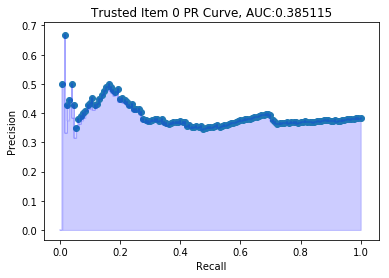

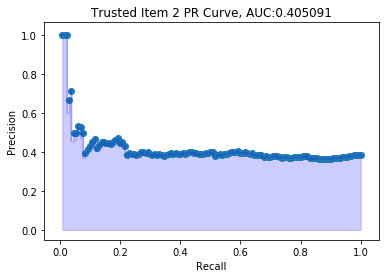

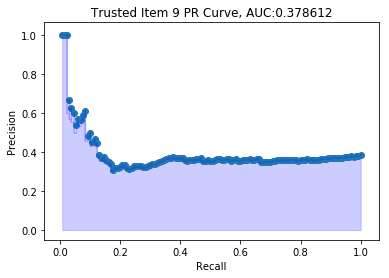

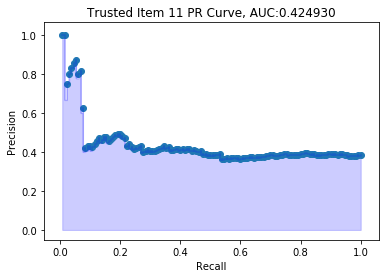

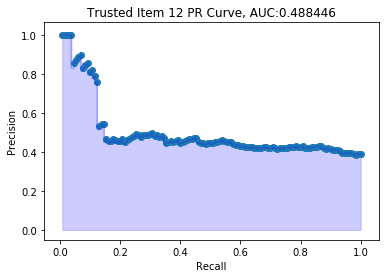

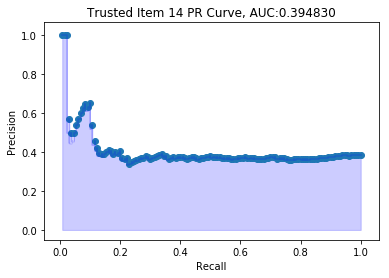

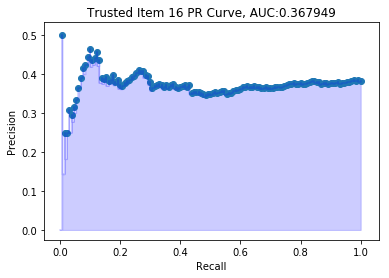

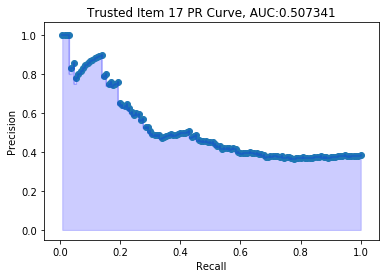

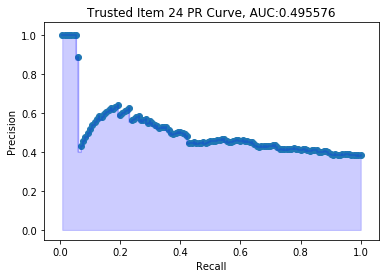

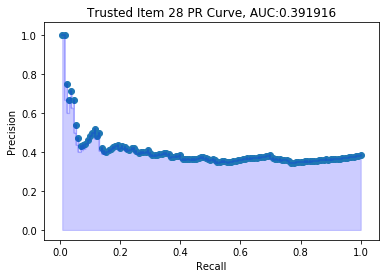

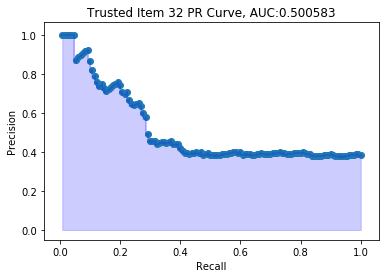

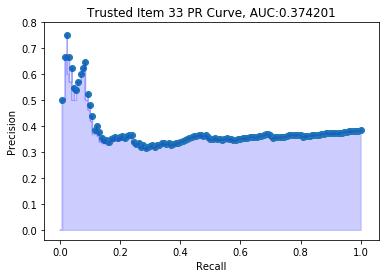

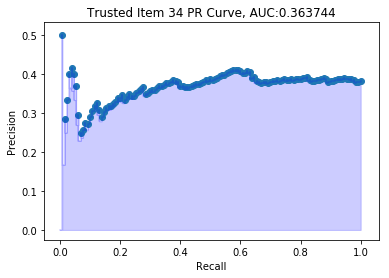

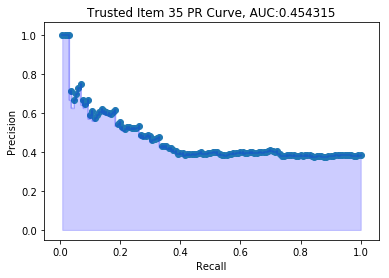

In [61]:
for ind in misclass:
# for ind in range(counts_dt.shape[0]):
    pr = True
    plot_pr_curve(counts_dt, ind, true_bugs, PR=pr, title='Trusted Item %d '%ind)

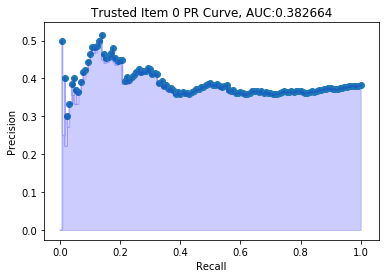

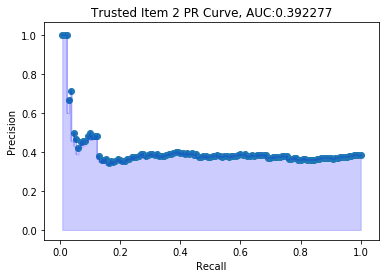

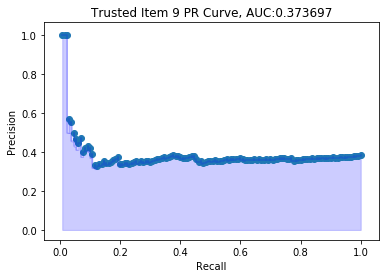

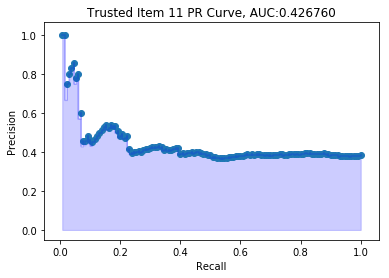

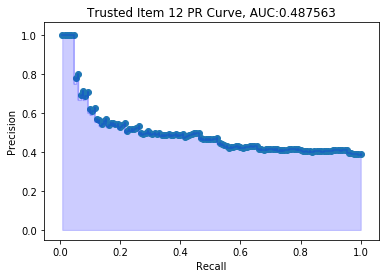

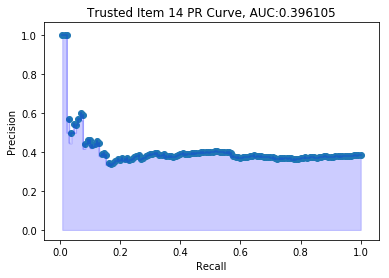

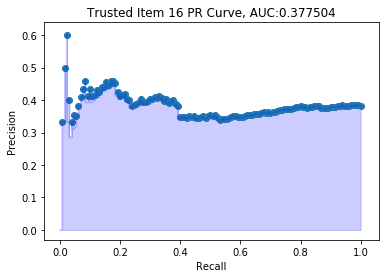

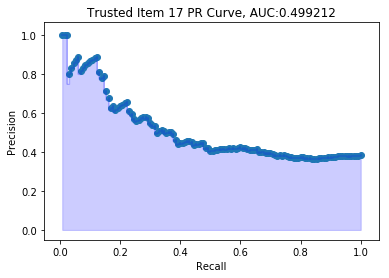

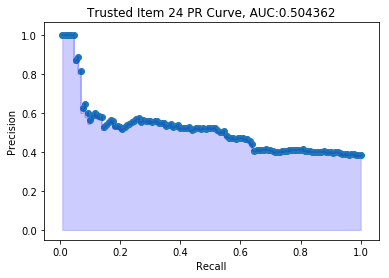

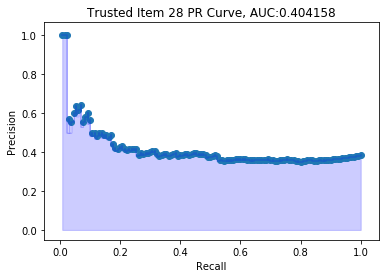

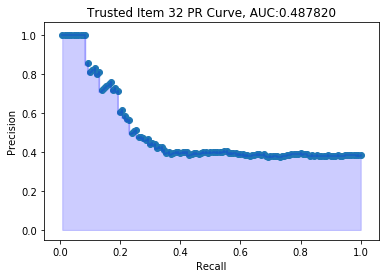

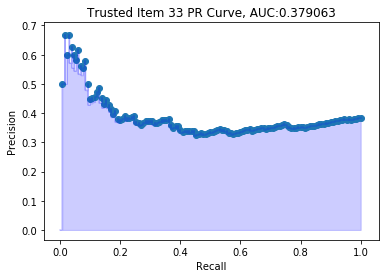

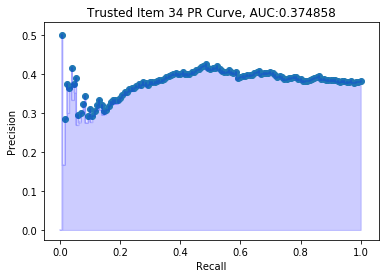

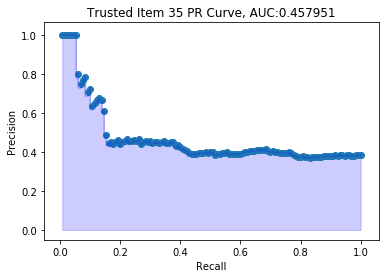

In [63]:
preds_dt = ovr_classifier(data_indices_X_dt, outputs_y_dt).T
for ind in misclass:
# for ind in range(counts_dt.shape[0]):
    pr = True
    plot_pr_curve(preds_dt, ind, true_bugs, PR=pr, title='Trusted Item %d '%ind)

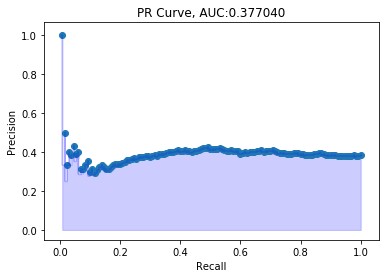

In [65]:
m = np.max(preds_dt, axis=0).reshape((1,preds_dt.shape[1]))
pr = True
plot_pr_curve(m, 0, true_bugs, PR=pr)

In [25]:
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier
def ovr_classifier(data_indices_X, outputs_y):
    
    est_clf = LogisticRegression(solver='lbfgs')
#     est_clf = MLPClassifier()

    ovr_clf = OneVsRestClassifier(est_clf)
    
    ovr_clf.fit(data_indices_X, outputs_y)
    
#     print(nn_clf.coefs_)
    
    X = np.identity(data_indices_X.shape[1])
    preds = ovr_clf.predict_proba(X)
    
    return preds
    

In [1]:
def bagging2(X_train, y_train, X_trust, y_trust, clf, ensemble_size, bootstrap_size=None, random_features=False):
    
    counts = np.zeros((X_trust.shape[0], X_train.shape[0]))
    total_counts = np.zeros((X_trust.shape[0], X_train.shape[0]))
    
    data_indices_X = np.zeros((ensemble_size, X_train.shape[0]))
    outputs_y = np.zeros((ensemble_size, X_trust.shape[0]))

    for i in tqdm(range(ensemble_size)):
        X_sample, y_sample, data_indices, feature_indices = sample_data(X_train, y_train, bootstrap_size, random_features)
        clf.fit(X_sample, y_sample)
        y_trust_pred = clf.predict(X_trust)
#         print(y_trust_pred.shape)
        
        for k in range(data_indices.shape[0]):
            data_indices_X[i][data_indices[k]] += 1
        
        for j in range(X_trust.shape[0]):
            # misclassified trusted item
            for k in range(data_indices.shape[0]):
                total_counts[j][data_indices[k]] += 1
            
            if(y_trust[j] != y_trust_pred[j]): 
                outputs_y[i][j] = 1
                for k in range(data_indices.shape[0]):
                    counts[j][data_indices[k]] += 1
                    
    return np.divide(counts,total_counts), data_indices_X, outputs_y         

In [2]:
def sklearn_pr_curve(metric, bugs):
    precision, recall, thres = pr_curve(bugs, metric)
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    
    print(thres)
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR Curve')

In [3]:
from sklearn.metrics import roc_auc_score
from sklearn import metrics
def plot_pr_curve(metric, ind, bugs, PR=True, title=None):
    # precision = tp/(tp+fp)
    # recall = tp/(tp + fn)
    precision = []
    recall = []
    tp_list = []
    fp_list = []
    found = [[],[]]
    num_bugs = np.sum(bugs)
    
    tp = 0
    fp = 0
    
    a = metric[ind]
    duo = [(i,a[i]) for i in range(a.shape[0])]
    duo.sort(key=lambda x: x[1], reverse=True)
#     print("(Index of bug, TP, FP)")

    for ind,_ in duo:
        
        if(bugs[ind]==1):
            tp += 1
        else:
            fp += 1
        tp_list.append(tp)
        fp_list.append(fp)
        
        pr = tp/(tp+fp)
        re = tp/num_bugs
#         print("(%d,%d,%d)"%(ind,tp,fp), end=", ")
        precision.append(pr)
        recall.append(re)
        
        if(bugs[ind]==1):
            if PR:
                found[0].append(re)
                found[1].append(pr)
            else:
                found[0].append(fp)
                found[1].append(tp)
        
    plt.figure()
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    
    if PR:
        x = recall
        y = precision
        t = 'PR Curve, AUC:%f'
        x_label = 'Recall'
        y_label = 'Precision'
        total_area = 1
    else:
        x = fp_list
        y = tp_list
        t = 'TP vs FP Curve, AUC:%f'
        x_label = 'FP'
        y_label = 'TP'
        total_area = tp*fp
    
    area = metrics.auc(x, y)/total_area
    plt.step(x, y, color='b', alpha=0.2, where='post')
    plt.fill_between(x, y, alpha=0.2, color='b', **step_kwargs)
    
    plt.scatter(found[0], found[1])
    
    t = t%area
    if title:
        t = title + t
    plt.title(t)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
        

In [4]:
def subset_indices(n, m=None):
    
    # Samples m numbers uniformly at random with replacement from 0,...,n-1 : bootstrap of size m
    if m is not None:
        indices = np.floor(np.random.rand(m)*n).astype(int)
    # If m not specified, random (non-empty) subset is returned
    else:
        indices = np.nonzero(np.round(np.random.rand(n)))[0]
        if indices.shape[0] == 0:
            indices = subset_indices(n)
        
    return indices

In [5]:
def sample_data(X, y, bootstrap_size=None, random_features=False):
    # if bootstrap_size is None, then random subset returned
    data_indices = subset_indices(X.shape[0], bootstrap_size)
    if random_features:
        feature_indices = subset_indices(X.shape[1])
        X_sample = X[data_indices, feature_indices]
        X_sample = np.reshape(X_sample, (data_indices.shape[0],feature_indices.shape[0]))
    else:
        X_sample = X[data_indices, :]
        feature_indices = np.array(range(X.shape[1]))
    y_sample = y[data_indices]
    
    return X_sample, y_sample, data_indices, feature_indices

# plotting

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram

In [7]:
# ----------------------------------------
# For plotting data
def plot_model(X_train, y_train, clf, X_trust=None, y_trust=None, title=None, 
													train_cluster_labels=None, trust_cluster_labels=None):
	
	pca = PCA(n_components=2)
	X_train_2d = pca.fit_transform(X_train)
	X_trust_2d = pca.transform(X_trust)

	# X = np.zeros((10000,2))
	# a = np.linspace(0,1,100)
	# b = np.linspace(0,1,100)
	# e, d = np.meshgrid(a, b)
	# X[:,0] = np.reshape(e,(10000,))
	# X[:,1] = np.reshape(d,(10000,))

	# Z = clf.predict(X)
	# probs = clf.predict_proba(K)[:, 1].reshape(e.shape)

	plt.figure()

	# Put the result into a color plot
	# Z = Z.reshape(e.shape)
	# plt.contour(e, d, probs, levels=[0.5])

	# Plot clusters
	if train_cluster_labels is not None:
		if trust_cluster_labels is not None:
			cluster_labels = np.concatenate([train_cluster_labels,trust_cluster_labels])
			X = np.vstack([X_train_2d, X_trust_2d])
			plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, marker='o', s=80)
		else:
			plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=train_cluster_labels, marker='o', s=80)

	# Plot the training points
	plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, cmap=plt.cm.Paired, marker='.')
	
	# Plot the trusted points
	if X_trust_2d is not None:
		plt.scatter(X_trust_2d[:, 0], X_trust_2d[:, 1], c=y_trust, cmap=plt.cm.Paired, marker='X')

	if title is not None:
		plt.title(str(title))

	plt.xlabel('x1')
	plt.ylabel('x2')
	plt.draw()